Implement and test the 3 conditions of Schaal14 for shock detection

In [1]:
import sys
sys.path.append('/Users/paolamartire/shocks')

import numpy as np
import matplotlib.pyplot as plt

from grid_maker import make_grid
from Utilities.operators import calc_div, calc_grad, zero_interpolator, tree_interpolator
import Utilities.prelude


In [2]:
gamma = 5/3
mach_min = 1.3
num = 45

In [3]:
cross_section = True

# make the grid
_, gridded_den, gridded_T, gridded_P, gridded_Vx, gridded_Vy, gridded_Vz, gridded_V, gridded_Rcell, x_radii, y_radii, z_radii = make_grid(num)

# check the dimension of simulations cells: it has to be smaller than the one of your grid
Rcell_min = np.min(gridded_Rcell)
Rcell_max = np.max(gridded_Rcell)
dx = (x_radii[-1]-x_radii[0])/num
print(f'our grid: {np.round(dx,3)}, R_cell: {np.round(Rcell_min,3)}-{np.round(Rcell_max,3)}') #to check is is higher than min(Rcell)


all T=0, bro. CHANGE!
Tree built!
our grid: 0.044, R_cell: 0.019-0.053


In [4]:
def temperature_bump(mach, gamma):
    """ T_post/ T_pre shock """
    Tbump =  (mach**2 * (gamma-1) + 2) * (2 * gamma * mach**2 - (gamma-1)) / (mach**2 * (gamma+1)**2)
    return Tbump

def pressure_bump(mach, gamma):
    """ P_post/ P_pre shock"""
    Pbump = (2 * gamma * mach**2 - (gamma-1)) / (gamma+1)
    return Pbump

def shock_direction(x_array, y_array, z_array, Tgrid, idx):
    """ Find shock direction according eq.(5) by Schaal14 in the point of coordinates indices idx"""
    gradT = calc_grad(x_array, y_array, z_array, Tgrid, idx, kind_info = 'idx')
    magnitude = np.linalg.norm(gradT)
    ds = - np.array(gradT) / magnitude 
    return ds

def condition3(x_array, y_array, z_array, Tgrid, Pgrid, idx, deltax, mach_min, gamma):
    i = idx[0]
    j = idx[1]
    k = idx[2]
    xyz = [x_array[i], y_array[j], z_array[k]]
    ds = shock_direction(x_array, y_array, z_array, Tgrid, idx)
    post = xyz + ds*deltax
    pre = xyz - ds*deltax

    Tpost = zero_interpolator(x_array, y_array, z_array, Tgrid, post)
    Tpre = zero_interpolator(x_array, y_array, z_array, Tgrid, pre)
    Ppost = zero_interpolator(x_array, y_array, z_array, Pgrid, post)
    Ppre = zero_interpolator(x_array, y_array, z_array, Pgrid, pre)

    # Tpre, Ppre, Tpost, Ppost  = tree_interpolator(pre, post)

    delta_logT = np.log(Tpost)-np.log(Tpre)
    Tjump = temperature_bump(mach_min, gamma)
    Tjump = np.log(Tjump)
    ratioT = - delta_logT / Tjump # we take the - because we are in the lab (NOT shock) frame

    delta_logP = np.log(Ppost)-np.log(Ppre)
    Pjump = pressure_bump(mach_min, gamma)
    Pjump = np.log(Pjump)
    ratioP = - delta_logP / Pjump # we take the - because we are in the lab (NOT shock) frame
    
    if np.logical_and(ratioT >= 1, ratioP >= 1): 
        return True
    else:
        return False
    
def shock_zone(x_array, y_array, z_array, Vx_grid, Vy_grid, Vz_grid, T_grid, den_grid, idx, cond3, check_cond = '3'):
    """ Find the shock zone according conditions in Sec. 2.3.2 of Schaal14. """
    cond1 = calc_div(x_array, y_array, z_array, Vx_grid, Vy_grid, Vz_grid, idx, 'idx')
    gradT = calc_grad(x_array, y_array, z_array, T_grid, idx, 'idx')
    gradP = calc_grad(x_array, y_array, z_array, den_grid, idx, 'idx')

    if check_cond == '1' or check_cond == '2':
        cond3 = True #so you don't check it
        if check_cond == '2':
            cond2 = np.dot(gradT, gradP)
        else:
            cond2 = 10
    else:
        cond2 = np.dot(gradT, gradP)

    if np.logical_and(cond1<0, np.logical_and(cond2 > 0, cond3 == True)):
        return True
    else:
        return False

In [5]:
middle_zidx = int(len(z_radii)/2)
X_shock1 = []
Y_shock1 = []
Z_shock1 = []
X_shock2 = []
Y_shock2 = []
Z_shock2 = []
X_shock = []
Y_shock = []
Z_shock = []

for i in range(1, len(x_radii)-1):
    for j in range(1,len(y_radii)-1):
        for k in range(middle_zidx, middle_zidx+1):#len(1, z_radii)-1):
            # we don't consider the first and last point of the tree
            idx = [i,j,k]
            cond3 = condition3(x_radii, y_radii, z_radii, gridded_T, gridded_P, idx, dx, mach_min, gamma) 
            # shock1 = shock_zone(x_radii, y_radii, z_radii, gridded_Vx, gridded_Vy, gridded_Vz, gridded_T, gridded_den, idx, cond3, '1')
            # shock2 = shock_zone(x_radii, y_radii, z_radii, gridded_Vx, gridded_Vy, gridded_Vz, gridded_T, gridded_den, idx, cond3, '2')
            shock = shock_zone(x_radii, y_radii, z_radii, gridded_Vx, gridded_Vy, gridded_Vz, gridded_T, gridded_den, idx, cond3)
            
            # if shock1 == True:
            #     X_shock1.append(x_radii[i])
            #     Y_shock1.append(y_radii[j])
            #     Z_shock1.append(z_radii[k])

            # if shock2 == True:
            #     X_shock2.append(x_radii[i])
            #     Y_shock2.append(y_radii[j])
            #     Z_shock2.append(z_radii[k])

            if shock == True:
                X_shock.append(x_radii[i])
                Y_shock.append(y_radii[j])
                Z_shock.append(z_radii[k])

[-0.8181818181818181, -0.7727272727272727, -0.7727272727272727, -0.7727272727272727, -0.7727272727272727, -0.7727272727272727, -0.7727272727272727, -0.7727272727272727, -0.7727272727272727, -0.7727272727272727, -0.7727272727272727, -0.7272727272727273, -0.7272727272727273, -0.7272727272727273, -0.7272727272727273, -0.7272727272727273, -0.7272727272727273, -0.7272727272727273, -0.7272727272727273, -0.7272727272727273, -0.7272727272727273, -0.7272727272727273, -0.7272727272727273, -0.7272727272727273, -0.7272727272727273, -0.6818181818181819, -0.6818181818181819, -0.6818181818181819, -0.6818181818181819, -0.6818181818181819, -0.6818181818181819, -0.6818181818181819, -0.6818181818181819, -0.6818181818181819, -0.6818181818181819, -0.6818181818181819, -0.6818181818181819, -0.6818181818181819, -0.6818181818181819, -0.6818181818181819, -0.6818181818181819, -0.6818181818181819, -0.6818181818181819, -0.6818181818181819, -0.6818181818181819, -0.6363636363636364, -0.6363636363636364, -0.636363636

In [6]:
if cross_section == True:
    with open(f'shockzone_num{num}.txt', 'a') as file:
        file.write(f'# Coordinates of the points in the shock zone at z = {z_radii[middle_zidx]}, num = {num}, mach_min = {mach_min} \n#X \n') 
        file.write(' '.join(map(str, X_shock)) + '\n')
        file.write('# Y \n') 
        file.write(' '.join(map(str, Y_shock)) + '\n')
        file.close()

/var/folders/s6/3n46ppqn3jx7765w8c686c740000gn/T/ipykernel_38919/1563433191.py:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ks" (-> color='k'). The keyword argument will take precedence.
  plt.plot(X_shock1, Y_shock1, 'ks', c = 'k', markerfacecolor='none', ms=8, markeredgecolor='coral', label = '1')
/var/folders/s6/3n46ppqn3jx7765w8c686c740000gn/T/ipykernel_38919/1563433191.py:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ks" (-> color='k'). The keyword argument will take precedence.
  plt.plot(X_shock2, Y_shock2, 'ks', c = 'k', markerfacecolor='orange', ms=6, markeredgecolor='orange', label = '12')
/var/folders/s6/3n46ppqn3jx7765w8c686c740000gn/T/ipykernel_38919/1563433191.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ks" (-> color='k'). The keyword argument will take precedence.
  plt.plot(X_shock, Y_shock, 'ks', c = 'k', markerf

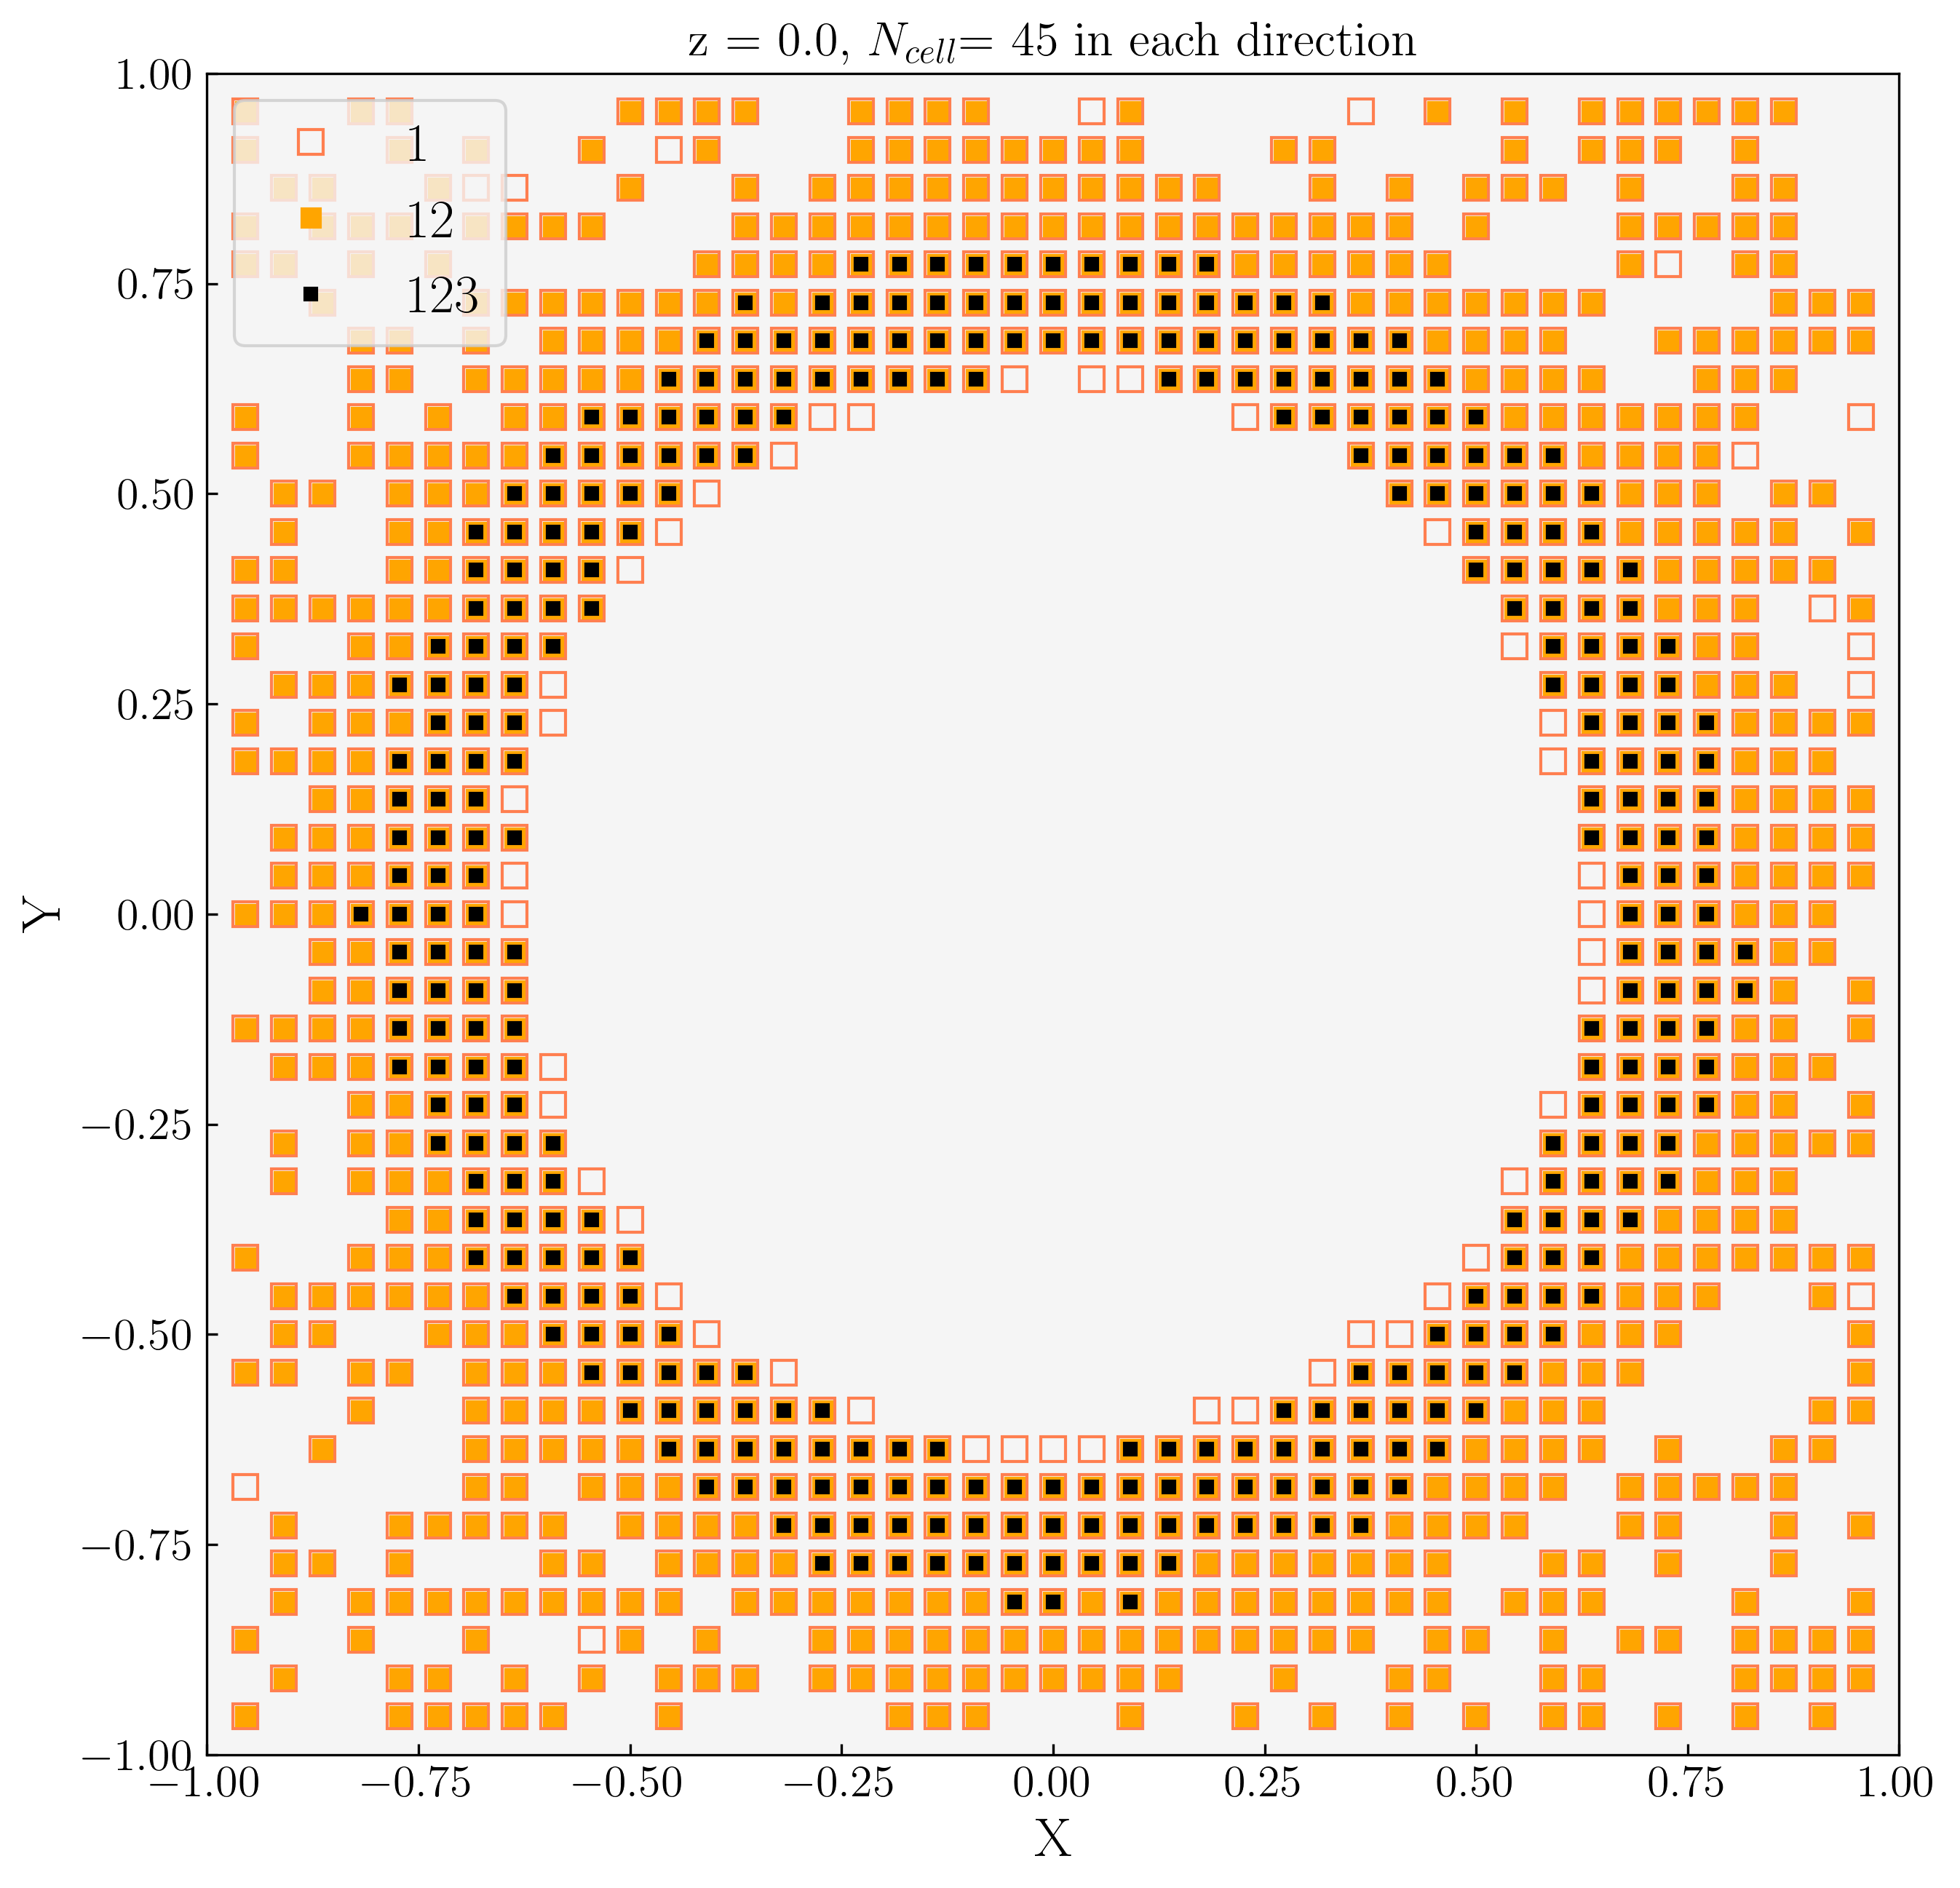

In [7]:
plt.figure(figsize=(10,10))
plt.plot(X_shock1, Y_shock1, 'ks', c = 'k', markerfacecolor='none', ms=8, markeredgecolor='coral', label = '1')
plt.plot(X_shock2, Y_shock2, 'ks', c = 'k', markerfacecolor='orange', ms=6, markeredgecolor='orange', label = '12')
plt.plot(X_shock, Y_shock, 'ks', c = 'k', markerfacecolor='k', ms=4, markeredgecolor='k', label = '123')
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.xlabel('X', fontsize = 18)
plt.ylabel('Y', fontsize = 18)
plt.title(f'z = {np.round(z_radii[middle_zidx],3)}, '+ r'$N_{cell}$'+ f'= {num} in each direction', fontsize = 16)
plt.legend(loc = 'upper left', fontsize = 18)
#plt.savefig('Figs/shockzone_conditions.png')
plt.show()

/var/folders/s6/3n46ppqn3jx7765w8c686c740000gn/T/ipykernel_38919/41311484.py:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ks" (-> color='k'). The keyword argument will take precedence.
  plt.plot(plot0[0], plot0[1], 'ks', c = 'k', markerfacecolor='none', ms=6, markeredgecolor = 'k', label = 'zero order')
/var/folders/s6/3n46ppqn3jx7765w8c686c740000gn/T/ipykernel_38919/41311484.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ks" (-> color='k'). The keyword argument will take precedence.
  plt.plot(plot1[0], plot1[1], 'ks', c = 'k', markerfacecolor='orange', ms=4, markeredgecolor = 'orange', label = 'tree')


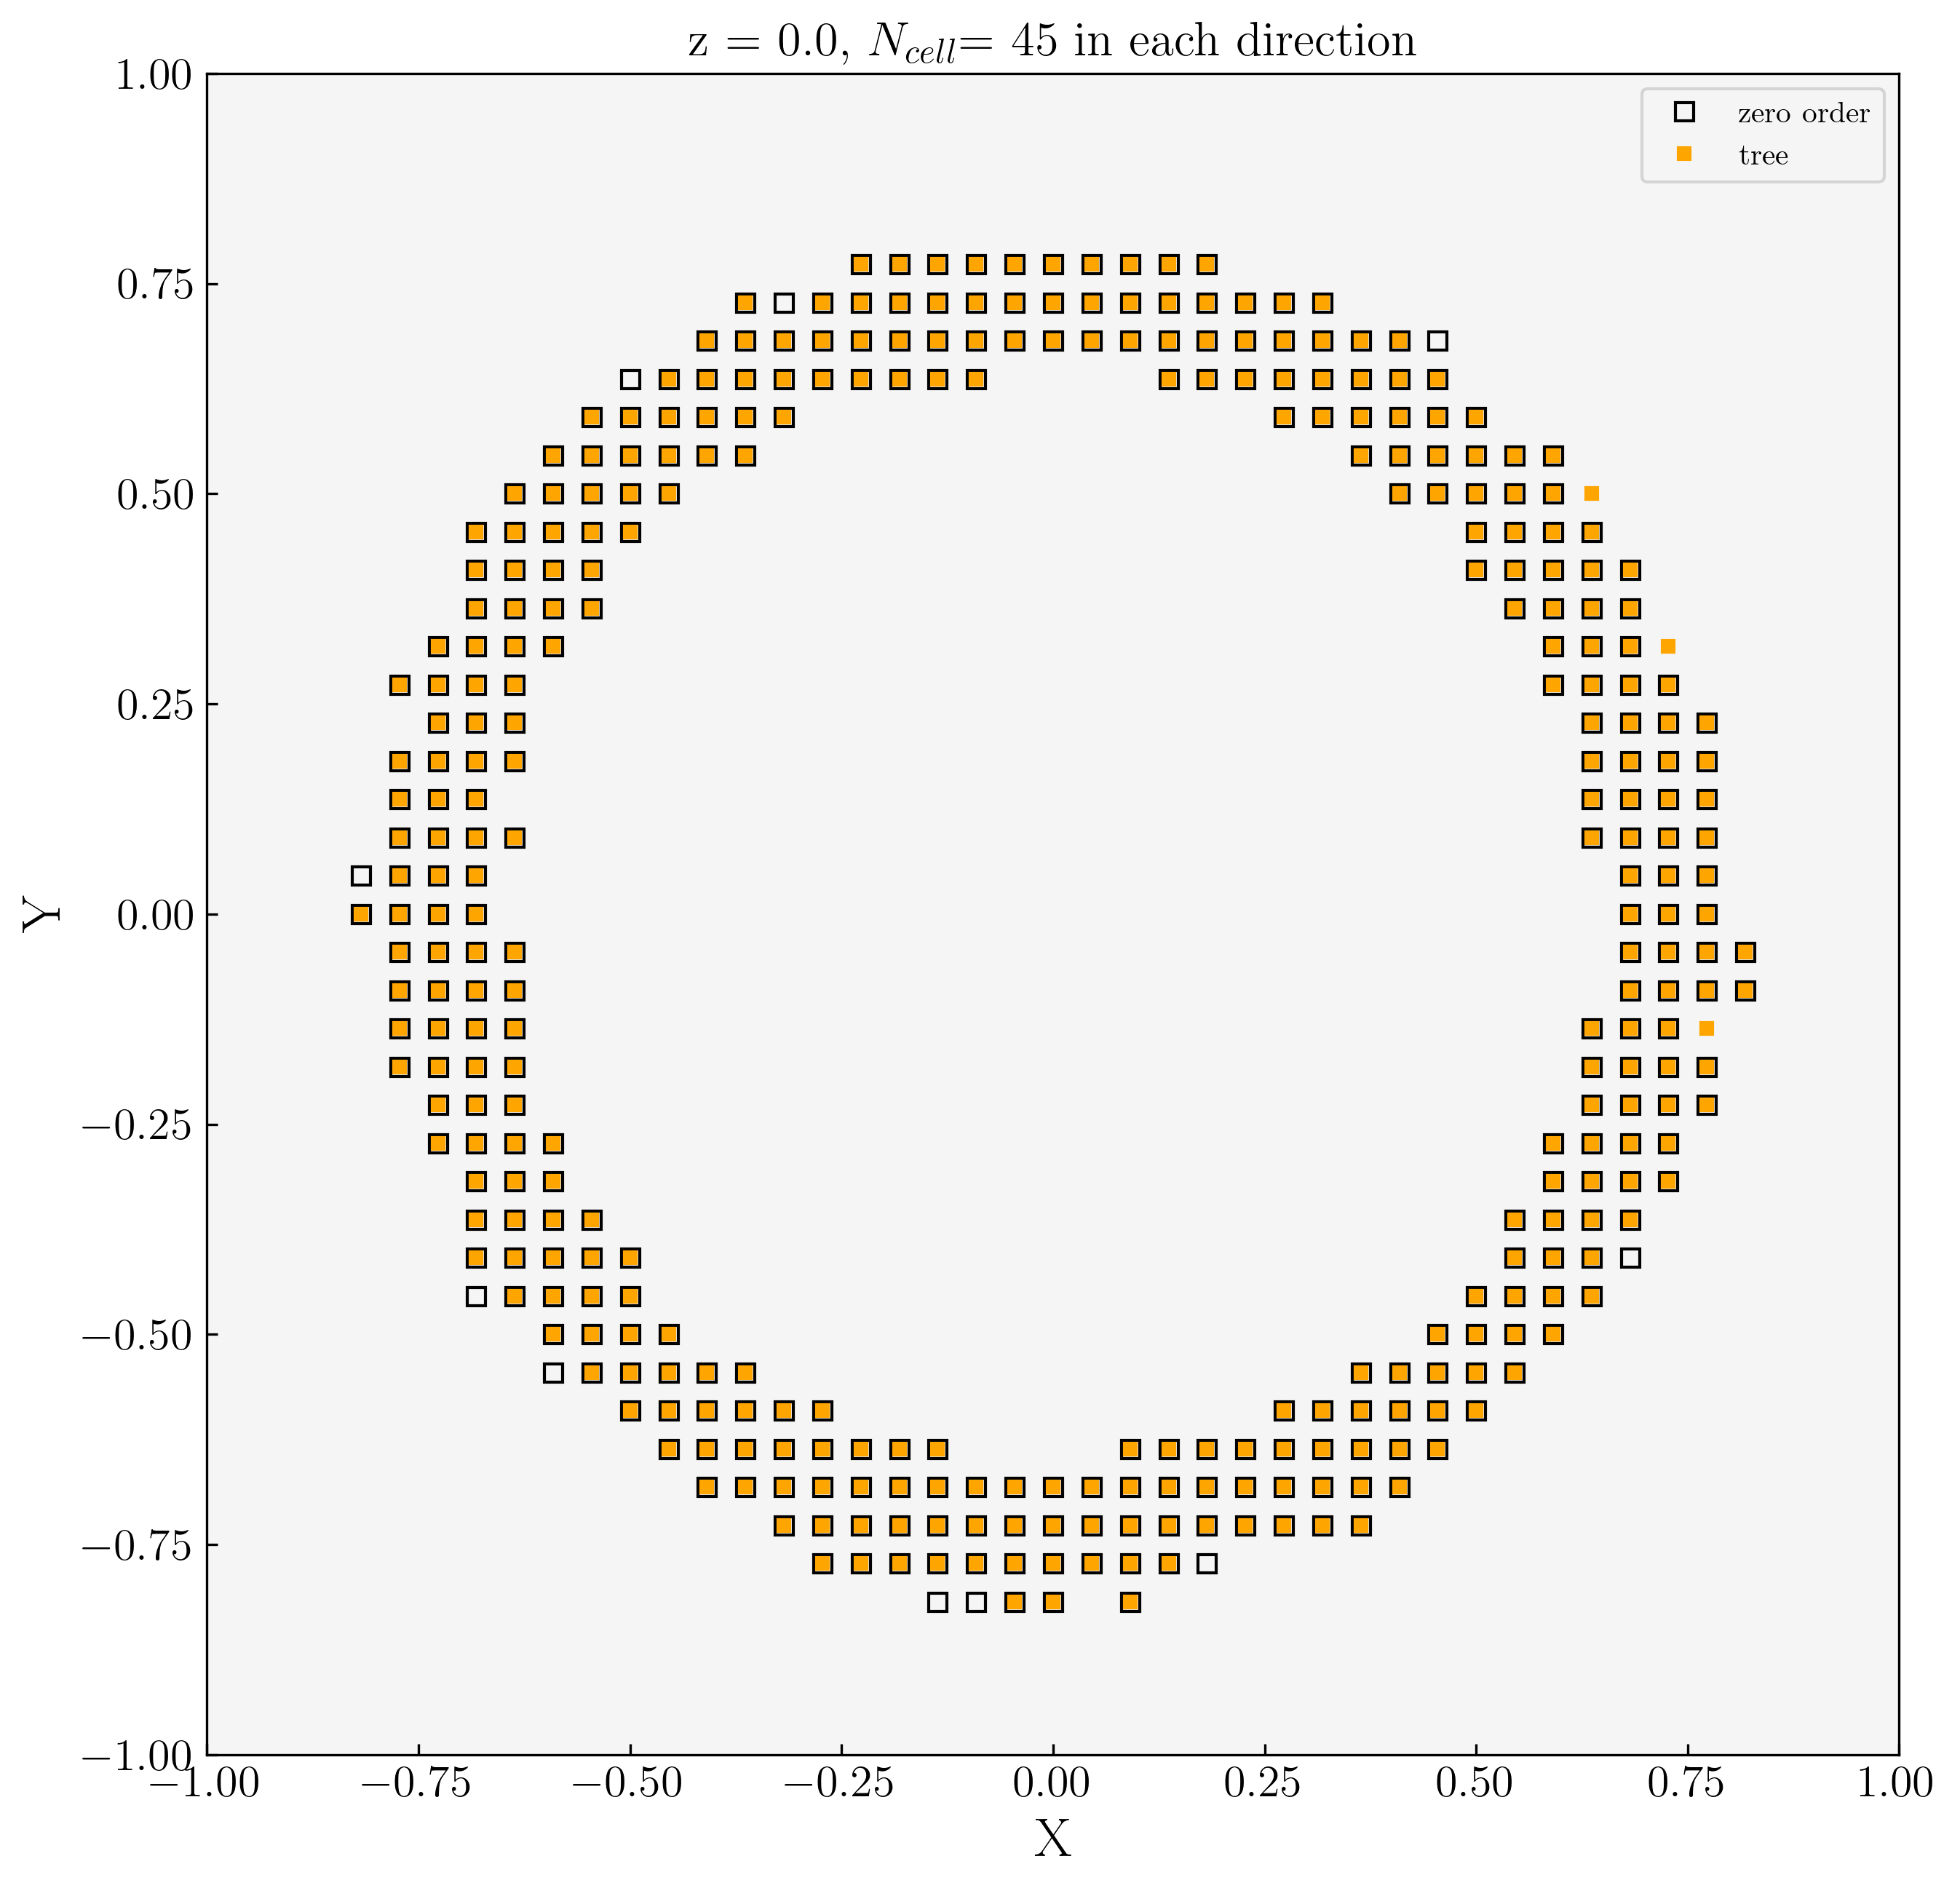

In [10]:
# #Plot to check the interpolators
# plot0 = np.loadtxt('shockzone_z0_zeroint.txt')
# plot1 = np.loadtxt('shockzone_z0_treeint.txt')
# plt.figure(figsize=(10,10))
# plt.plot(plot0[0], plot0[1], 'ks', c = 'k', markerfacecolor='none', ms=6, markeredgecolor = 'k', label = 'zero order')
# plt.plot(plot1[0], plot1[1], 'ks', c = 'k', markerfacecolor='orange', ms=4, markeredgecolor = 'orange', label = 'tree')
# plt.xlim(-1,1)
# plt.ylim(-1,1)
# plt.xlabel('X', fontsize = 18)
# plt.ylabel('Y', fontsize = 18)
# plt.title(f'z = {np.round(z_radii[middle_zidx],3)}, '+ r'$N_{cell}$'+ f'= {num} in each direction', fontsize = 16)
# plt.legend()
# plt.savefig('Figs/shockzone_interpComp.png')
# plt.show()
